# Computation Code for Blending in LSST Clustering 
## Ben Levine

In [42]:
import sys
sys.path.insert(0, "../../Assets/FoFCatalogMatching-master")
sys.path.insert(0, '/global/homes/l/levine/gcr-catalogs')
sys.path.insert(0, "../.local/lib/python3.7/site-packages")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from astropy.coordinates import SkyCoord

import FoFCatalogMatching
import GCRCatalogs

import kmeans_radec
from kmeans_radec import KMeans, kmeans_sample

import healpy as hp
import fitsio
import glob
import pandas as pd

import pyccl as ccl
import treecorr as tc
import pickle

# Import Galaxy Catalogs

In [2]:
#This file path should lead to the target catalogs folder
GCRCatalogs.__file__

'/global/homes/l/levine/gcr-catalogs/GCRCatalogs/__init__.py'

In [3]:
#Define cuts on the catalogs
from GCR import GCRQuery
obj_mag_cuts = [
    GCRQuery('mag_i_lsst < 25'),
    GCRQuery((np.isfinite, 'mag_i_lsst')),
    GCRQuery('is_star == False'),
    GCRQuery('redshift_true < 1.2'),
]

truth_mag_cuts = [
    GCRQuery('mag_i_lsst < 25'),
    GCRQuery((np.isfinite, 'mag_i_lsst')),
]

In [4]:
gc_matched = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd_matched_addon')
#gc_matched.available_tracts

/global/homes/l/levine/gcr-catalogs/GCRCatalogs/register.py:366: UserWarning: `dc2_object_run2.2i_dr6_wfd_with_metacal` is currently an alias of `dc2_object_run2.2i_dr6_wfd_v1_with_metacal`.Please be advised that it will soon change to point to an updated version `dc2_object_run2.2i_dr6_v1_with_addons`.The updated version is already available in the master branch.
  self.rootname, self[self.ALIAS_KEY], online_config.get(self.ALIAS_KEY),


In [5]:
#Import the Observed catalog
#gc_matched = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd_matched_addon')
observed_data = pd.DataFrame(gc_matched.get_quantities(['ra', 'dec', 
                                     'n_neigh_truth', 'n_neigh_object', 
                                     'mag_i_lsst', 'redshift_true',], filters=obj_mag_cuts,))

#Extra quantities of interest: 'is_matched', 'truthId'

In [6]:
#Separate the data into one-multiple (otm) and one-one (oto) matches
mask_otm = (observed_data['n_neigh_truth'] > 1)
mask_oto = (observed_data['n_neigh_truth'] == 1)
total_otm = observed_data[mask_otm]
total_oto = observed_data[mask_oto]
total_otm = total_otm.reset_index()
total_oto = total_oto.reset_index()

In [7]:
total_otm = pd.DataFrame({'ra':total_otm['ra'],'dec':total_otm['dec'],
                          'i':total_otm['mag_i_lsst'],'z':total_otm['redshift_true'],})
total_oto = pd.DataFrame({'ra':total_oto['ra'],'dec':total_oto['dec'],
                          'i':total_oto['mag_i_lsst'],'z':total_oto['redshift_true'],})

In [8]:
#We don't need the original catalog object anymore.
%reset_selective -f gc_matched

In [9]:
#Import randoms
flist = glob.glob('/global/cscratch1/sd/jsanch87/randoms_dr6c_10sigma_r26.fits.gz')
for i, fname in enumerate(flist):
    data = fitsio.read(fname)
    if i==0:
        total_rand = data
    else:
        total_rand = np.concatenate([total_rand, data])
total_rand = pd.DataFrame({'ra':np.array(total_rand['ra']).byteswap().newbyteorder(),
                          'dec':np.array(total_rand['dec']).byteswap().newbyteorder(),})

0


# Align Catalog Edges

In [10]:
#Remove missing tracts from random catalog
nside=2048
npix=hp.nside2npix(nside)
map_gal=np.bincount(hp.ang2pix(nside, total_otm['ra'], total_otm['dec'], lonlat=True), minlength=npix)
goodpx=np.where(map_gal>0)[0]

pxrnd=hp.ang2pix(nside, total_rand['ra'], total_rand['dec'], lonlat=True)
good_rnd = np.in1d(pxrnd, goodpx)

#Remove edges from object catalog
map_rand=np.bincount(hp.ang2pix(nside, total_rand['ra'], total_rand['dec'], lonlat=True), minlength=npix)
goodpx=np.where(map_rand>0)[0]

px_oto=hp.ang2pix(nside, total_oto['ra'], total_oto['dec'], lonlat=True)
good_oto = np.in1d(px_oto, goodpx)
px_otm=hp.ang2pix(nside, total_otm['ra'], total_otm['dec'], lonlat=True)
good_otm = np.in1d(px_otm, goodpx)

In [11]:
total_otm = total_otm[good_otm]
total_oto = total_oto[good_oto]
total_rand = total_rand[good_rnd]

In [12]:
#Random catalog should only be as long as the longest data catalog
max_length = np.maximum(len(total_oto['ra']),len(total_otm['ra']))
total_rand = total_rand.reset_index(); total_rand = total_rand.truncate(after=max_length-1)

# Calculate Data Correlation

In [13]:
#Apply Gaussian Redshift Distribution
total_otm['z_phot'] = total_otm['z'] + .05*(1 + total_otm['z'])*np.random.normal(size=len(total_otm['z']))
total_oto['z_phot'] = total_oto['z'] + .05*(1 + total_oto['z'])*np.random.normal(size=len(total_oto['z']))

In [25]:
def calc_correlation(catalog, zmin, zmax):
    '''Calculate angular correlation
    Inputs:
    ----------
    catalog - source catalog
    zmin & zmax - redshift bin edges
    
    Returns:
    -------
    r - angle
    w - angular correlation
    sqrt(var) - jackknife deviation
    '''
    bin_mask = (catalog['z_phot']>zmin) & (catalog['z_phot']<zmax)
    cat_length = len(catalog[bin_mask]['ra'])
    
    #RUN TREECORR
    #Define Catalogs
    rand_cat = tc.Catalog(ra=total_rand['ra'][0:cat_length], dec=total_rand['dec'][0:cat_length], 
                          ra_units='deg', dec_units='deg', npatch=120)
    data_cat = tc.Catalog(ra=catalog[bin_mask]['ra'], dec=catalog[bin_mask]['dec'], ra_units='deg', dec_units='deg',
                         patch_centers=rand_cat.patch_centers)

    #Define TC Objects
    min_sep = .1
    max_sep = 200
    nbins = 20
    
    dd_truth = tc.NNCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, sep_units='arcmin', var_method='jackknife')
    dr_truth = tc.NNCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, sep_units='arcmin', var_method='jackknife')
    rr_rand = tc.NNCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, sep_units='arcmin', var_method='jackknife')
    
    #Process Objects
    dd_truth.process(data_cat)
    rr_rand.process(rand_cat)
    dr_truth.process(data_cat, rand_cat)
    
    w, var = dd_truth.calculateXi(rr_rand, dr_truth)
    
    return dd_truth.meanr, w, np.sqrt(var) 

In [33]:
def correlation_helper(catalog, n_bins):
    '''Calculate angular correlation for a set of bins
    Inputs:
    ----------
    catalog - source catalog
    n_bins - number of bins (Note: for this study, n_bins will be either 5 or 10)
    
    Returns:
    -------
    list of correlation data
    '''
    zmin = 0.2; zmax = 1.2 
    binlist = np.linspace(zmin,zmax,n_bins+1)
    output_list = []
    for i in range(n_bins):
        z1 = binlist[i]; z2 = binlist[i+1]        
        output_list.append(calc_correlation(catalog, z1, z2))
        
    return output_list

In [43]:
%%time
#These can take a long time to calculate so we will run once and then store in pickle.
oto_5 = correlation_helper(total_oto, 5)
otm_5 = correlation_helper(total_otm, 5)

CPU times: user 7h 49min 7s, sys: 2min 8s, total: 7h 51min 15s
Wall time: 30min 22s


In [70]:
%%time
#Same for these, but they'll take even longer. Skip this section if possible.
oto_10 = correlation_helper(total_oto, 10)
otm_10 = correlation_helper(total_otm, 10)

CPU times: user 14h 51min 43s, sys: 3min 49s, total: 14h 55min 32s
Wall time: 56min 6s


In [71]:
#Dump to file
filename = 'Blending_5bin'
outfile = open(filename,'wb')
pickle.dump([oto_5,otm_5],outfile)
outfile.close()

filename = 'Blending_10bin'
outfile = open(filename,'wb')
pickle.dump([oto_10,otm_10],outfile)
outfile.close()

# Calculate Predicted Correlation 

In [77]:
#Load correlations from file
filename = 'Blending_5bin'
infile = open(filename,'rb')
oto_5,otm_5 = pickle.load(infile)
outfile.close()

filename = 'Blending_10bin'
infile = open(filename,'rb')
oto_10,otm_10 = pickle.load(infile)
outfile.close()

In [79]:
def calculate_z_distribution(catalog, zmin, zmax):
    '''Calculate histogram of redshift values
    Inputs:
    ----------
    catalog - source catalog
    zmin & zmax - redshift bin edges
    
    Returns:
    -------
    List of n(z) and list of bin centers
    '''
    bin_mask = (catalog['z_phot']>zmin) & (catalog['z_phot']<zmax)
    n_z, bin_edge = np.histogram(catalog['z'][bin_mask], bins=100, range=(0, 1.2))
    bin_centers = 0.5 * bin_edge[1:] + 0.5 * bin_edge[:-1]
    return n_z, bin_centers

In [81]:
cosmo = ccl.Cosmology(Omega_c=0.271, Omega_b=0.044, n_s=0.96, h=0.71, sigma8=0.8)
def predict_correlation(catalog, zmin, zmax, theta):
    '''Calculate predicted angular correlation
    Inputs:
    ----------
    catalog - source catalog
    zmin & zmax - redshift bin edges
    theta - list of theta values for predicted function
    
    Returns:
    -------
    w_theory - list of predicted correlations at each value of theta
    '''
    nz, zbins = calculate_z_distribution(catalog, zmin, zmax)
    tracer = ccl.NumberCountsTracer(cosmo, True, (zbins, nz), (zbins, np.ones_like(zbins)))
    ells = np.unique(np.geomspace(0.1, 50000, 100).astype(int))
    cls_out = ccl.angular_cl(cosmo, tracer, tracer, ells)   
    w_theory = ccl.correlation(cosmo, ells, cls_out, theta/60)
    
    return w_theory

In [85]:
def predict_correlation_helper(catalog, n_bins, corr_list):
    '''Calculate predicted correlation for a set of bins
    Inputs:
    ----------
    catalog - source catalog
    n_bins - number of bins (Note: for this study, n_bins will be either 5 or 10)
    corr_list - list of correlation functions given by correlation_helper() function
    
    Returns:
    -------
    list of predicted correlation data
    '''
    zmin = 0.2; zmax = 1.2 
    binlist = np.linspace(zmin,zmax,n_bins+1)
    output_list = []
    for i in range(n_bins):
        z1 = binlist[i]; z2 = binlist[i+1]
        output_list.append(predict_correlation(catalog, z1, z2, corr_list[i][0]))
        
    return output_list

In [89]:
oto_5_ccl = predict_correlation_helper(total_oto, 5, oto_5)
otm_5_ccl = predict_correlation_helper(total_otm, 5, otm_5)
oto_10_ccl = predict_correlation_helper(total_oto, 10, oto_10)
otm_10_ccl = predict_correlation_helper(total_otm, 10, otm_10)

# Calculate Biases

In [90]:
def chi2(b, w_obs, w_pred, err):
    return (w_obs - b**2 * w_pred) / err

In [97]:
import scipy.optimize as op
def compute_bias(w_data, w_ccl, w_var):
    '''Calculate best-fit bias value
    Inputs:
    ----------
    w_data - observed angular correlation
    w_pred - predicted angular correlation
    w_var - SQUARE ROOT of variance in correlation (since calc_correlation() returns the square root)
    
    Returns:
    -------
    b - best-fit value of bias
    b_var - uncertainty in b
    '''
    b, b_var,_,_,_ = op.leastsq(chi2, 1., (w_data, w_ccl, w_var), full_output=1)
    return b, np.sqrt(b_var)

In [98]:
def bias_helper(observed, predicted):
    '''Calculate best-fit bias value for a set of bins
    Inputs:
    ----------
    observed - list of observed correlations (from correlation_helper())
    predicted - list of predicted correlations (from predict_correlation_helper())
    
    Returns:
    -------
    List of best-fit biases
    '''
    bias_list = []
    for i in range(len(predicted)):
        bias_list.append(compute_bias(observed[i][1], predicted[i], observed[i][2]))
    
    return bias_list

In [100]:
b_oto_5 = bias_helper(oto_5,oto_5_ccl)
b_otm_5 = bias_helper(otm_5,otm_5_ccl)
b_oto_10 = bias_helper(oto_10,oto_10_ccl)
b_otm_10 = bias_helper(otm_10,otm_10_ccl)

# Display Data

In [120]:
zmin = 0.2; zmax = 1.2 
binlist_5 = np.linspace(zmin,zmax,6)
binlist_10 = np.linspace(zmin,zmax,11)
binlist_5 = 0.5 * binlist_5[1:] + 0.5 * binlist_5[:-1]
binlist_10 = 0.5 * binlist_10[1:] + 0.5 * binlist_10[:-1]

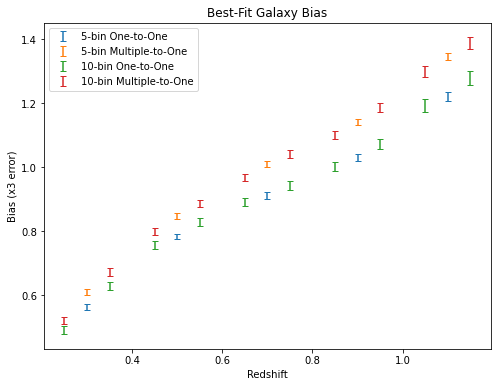

In [146]:
plt.figure(figsize=(8,6))
plt.title('Best-Fit Galaxy Bias')
plt.xlabel('Redshift')
plt.ylabel('Bias (x3 error)')
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_oto_5]), np.multiply(np.asarray([x[1] for x in b_oto_5]),3).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_5, np.asarray([x[0] for x in b_otm_5]), np.multiply(np.asarray([x[1] for x in b_otm_5]),3).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_oto_10]), np.multiply(np.asarray([x[1] for x in b_oto_10]),3).flatten(),
             ls='none', capsize=3)
plt.errorbar(binlist_10, np.asarray([x[0] for x in b_otm_10]), np.multiply(np.asarray([x[1] for x in b_otm_10]),3).flatten(),
             ls='none', capsize=3)
plt.legend(['5-bin One-to-One','5-bin Multiple-to-One','10-bin One-to-One','10-bin Multiple-to-One'])

In [180]:
def corr_plot_helper(observed_oto, predicted_oto, bias_oto, observed_otm, predicted_otm, bias_otm, bin_number):
    '''Plot correlation functions 
    Inputs:
    ----------
    observed correlation, predicted correlation, and bias, for the One-to-One and Multiple-to-One samples
    bin number of interest (counting up from 0)
    
    Returns:
    -------
    None
    '''
    zmin = 0.2; zmax = 1.2 
    n_bins = len(observed_oto)
    binlist = np.linspace(zmin,zmax,n_bins+1)
    zmin = binlist[bin_number]; zmax = binlist[bin_number+1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    fig.suptitle('Angular Correlation z ='+str(np.round(zmin,1))+'-'+str(np.round(zmax,1)))
    
    ax1.set_ylim([1e-5,1])
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax1.set_xlabel(r'$\theta$ (degrees)'); ax1.set_ylabel(r'$w(\theta)$')
    
    ax2.set_ylim([1e-5,1])
    ax2.set_xscale('log'); ax2.set_yscale('log')
    ax2.set_xlabel(r'$\theta$ (degrees)'); ax2.set_ylabel(r'$w(\theta)$')
    
    ax1.errorbar(observed_oto[bin_number][0], predicted_oto[bin_number] * (bias_oto[bin_number][0]**2),
                (predicted_oto[bin_number] * (bias_oto[bin_number][1]**2)).flatten())
    ax1.errorbar(observed_oto[bin_number][0], observed_oto[bin_number][1], observed_oto[bin_number][2])
    ax1.legend(['Predicted', 'Observed'], loc='lower left')
    ax1.set_title('One-to-One')
    
    ax2.errorbar(observed_otm[bin_number][0], predicted_otm[bin_number] * (bias_otm[bin_number][0]**2),
                (predicted_otm[bin_number] * (bias_otm[bin_number][1]**2)).flatten())
    ax2.errorbar(observed_otm[bin_number][0], observed_otm[bin_number][1], observed_otm[bin_number][2])
    ax2.legend(['Predicted', 'Observed'], loc='lower left')
    ax2.set_title('Multiple-to-One')

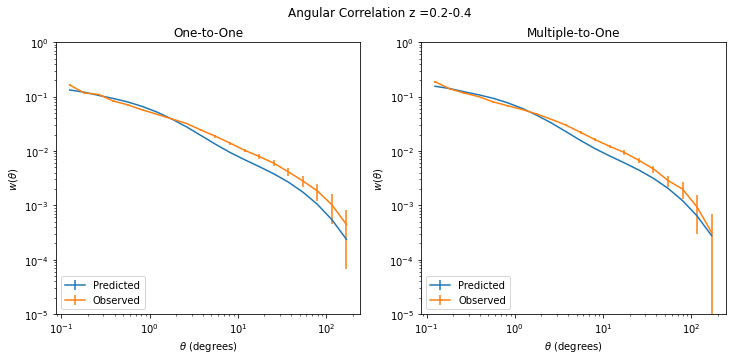

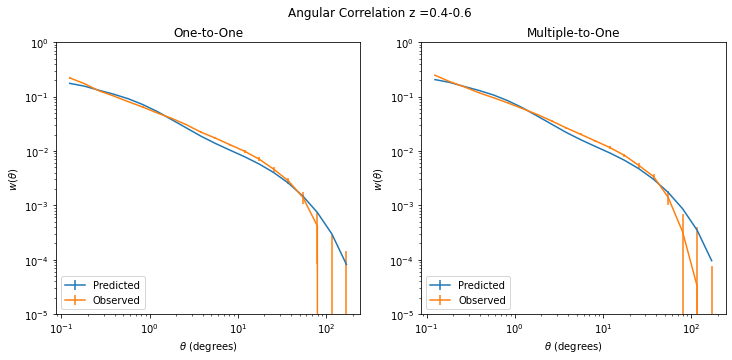

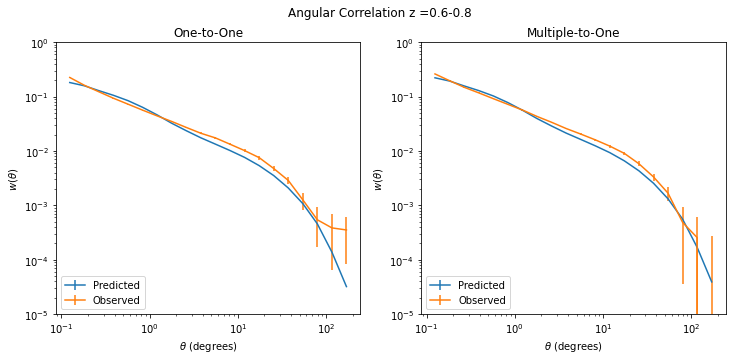

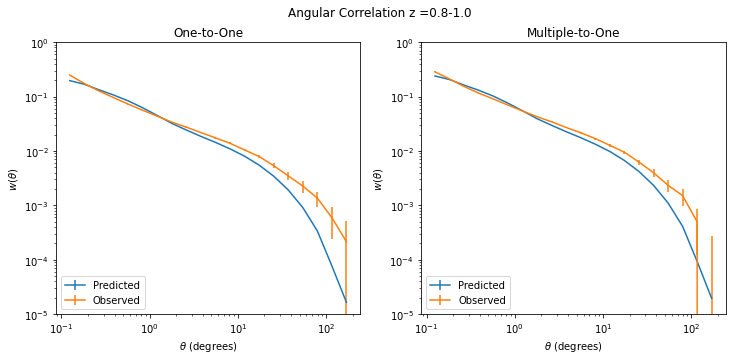

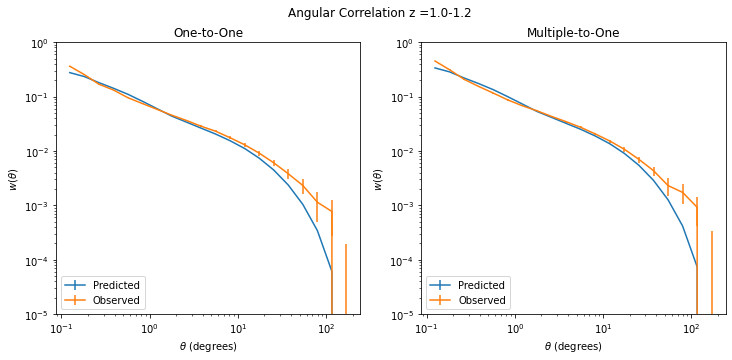

In [186]:
corr_plot_helper(oto_5,oto_5_ccl,b_oto_5,otm_5,otm_5_ccl,b_otm_5,0)
corr_plot_helper(oto_5,oto_5_ccl,b_oto_5,otm_5,otm_5_ccl,b_otm_5,1)
corr_plot_helper(oto_5,oto_5_ccl,b_oto_5,otm_5,otm_5_ccl,b_otm_5,2)
corr_plot_helper(oto_5,oto_5_ccl,b_oto_5,otm_5,otm_5_ccl,b_otm_5,3)
corr_plot_helper(oto_5,oto_5_ccl,b_oto_5,otm_5,otm_5_ccl,b_otm_5,4)

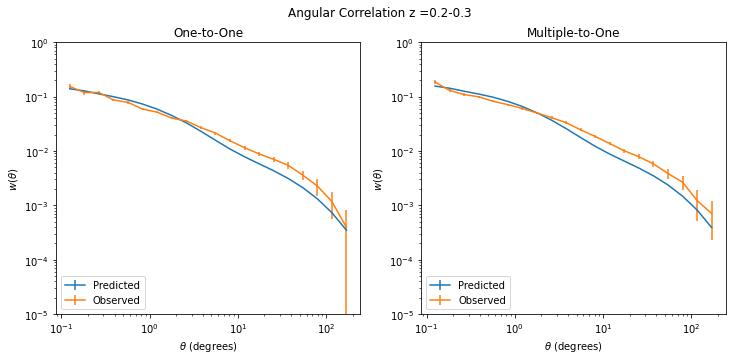

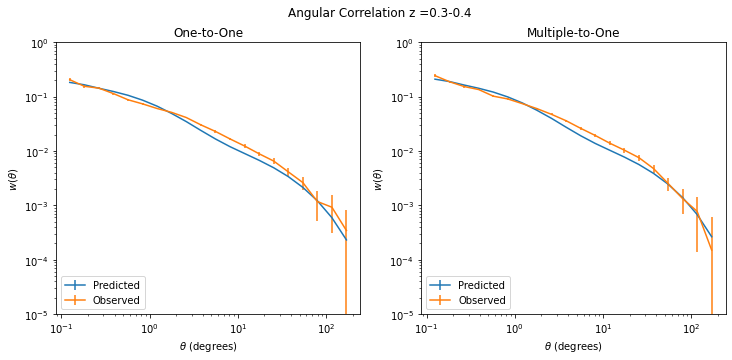

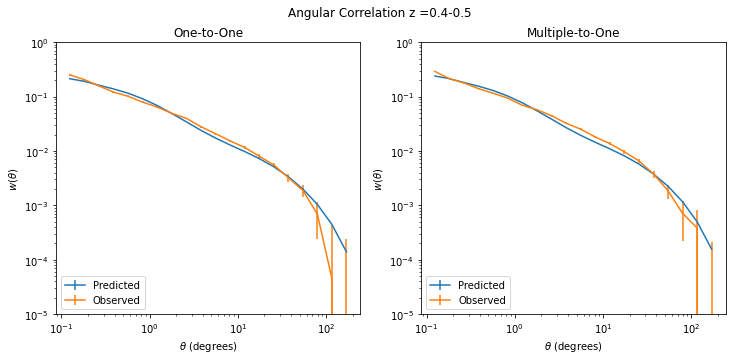

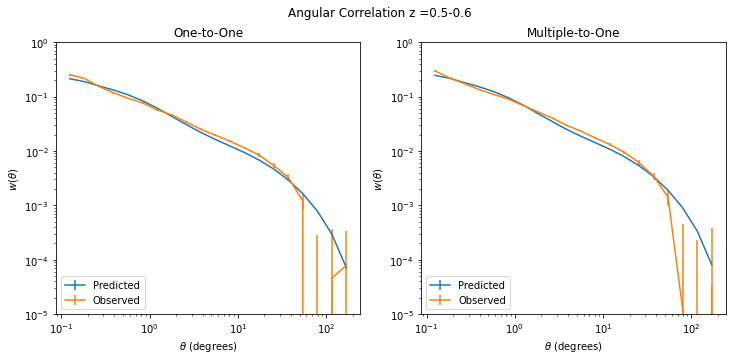

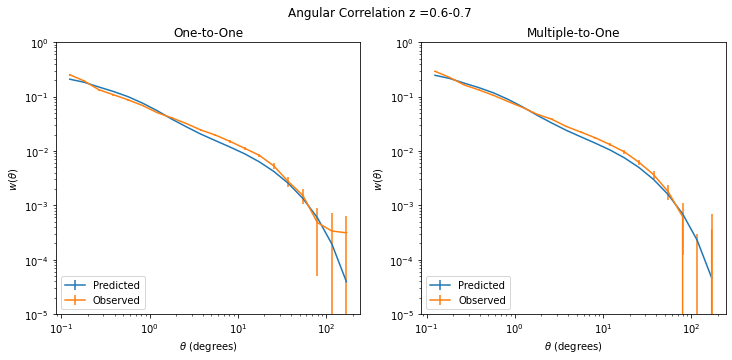

In [187]:
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,0)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,1)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,2)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,3)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,4)

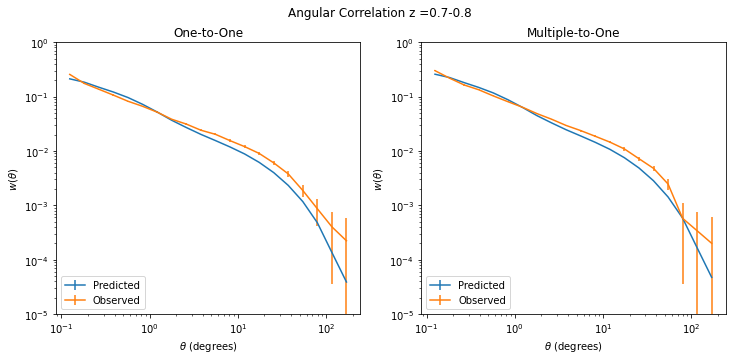

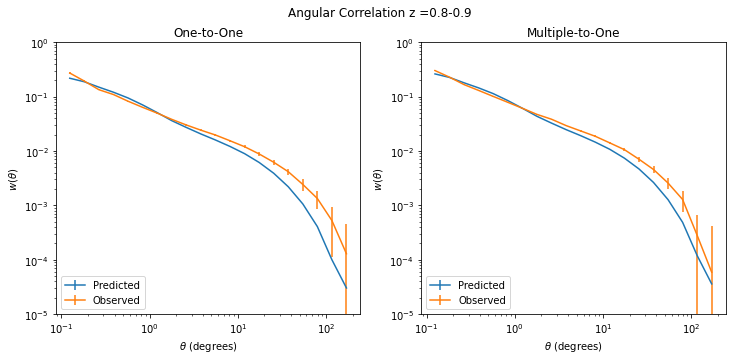

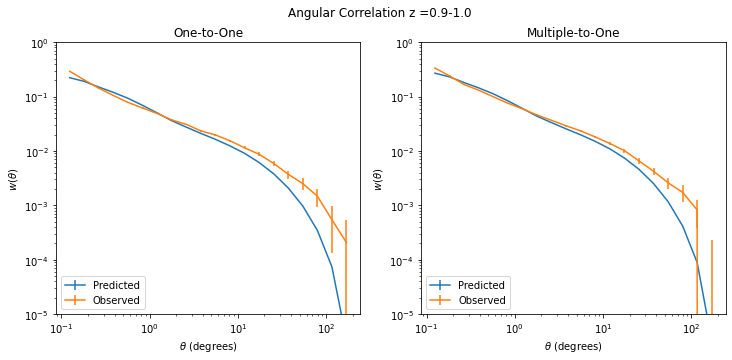

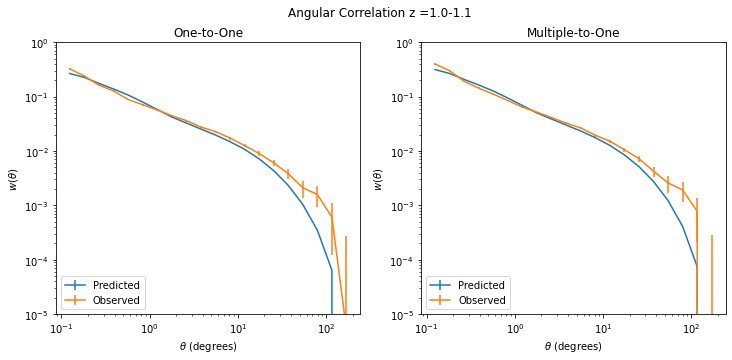

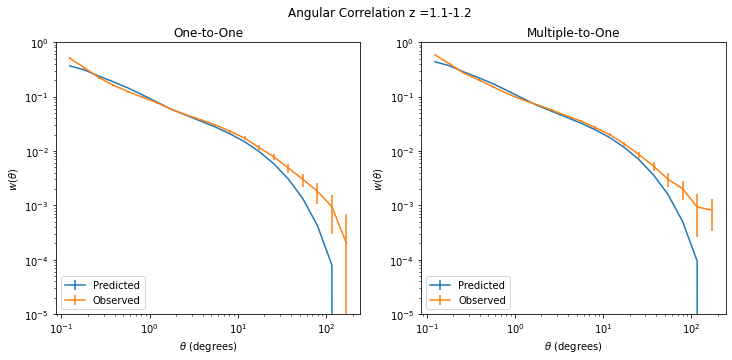

In [188]:
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,5)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,6)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,7)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,8)
corr_plot_helper(oto_10,oto_10_ccl,b_oto_10,otm_10,otm_10_ccl,b_otm_10,9)

# Additional Statistics

In [320]:
#The following cells require jackknifing

In [321]:
def jackknife_resample(func, data, bins):
    '''Compute jackknife resampling for a given function 
    Inputs:
    ----------
    func - input function
    data - input data catalog
    bins - number of jackknife bins
    
    Returns:
    -------
    list of means for each output of the function
    list of standard deviations for each output of the function
    '''
    jk_bins = np.random.randint(0,high=bins,size=len(data))
    
    output_list = []
    for i in range(bins):
        output_list.append(func(data[jk_bins != i]))
    
    return np.mean(output_list,axis=0), np.std(output_list,axis=0)

In [328]:
hist_statistic = lambda x: np.histogram(x, bins=100, range=(0,1.2), density=True)[0]
nz_oto, nz_sig_oto = jackknife_resample(hist_statistic, total_oto['z'], 10)
nz_otm, nz_sig_otm = jackknife_resample(hist_statistic, total_otm['z'], 10)
_, bin_edge = np.histogram(total_oto['z'], bins=100, range=(0, 1.2), density=True)
nz_bin_centers = 0.5 * bin_edge[1:] + 0.5 * bin_edge[:-1]

In [338]:
def propagate_division_error(z, x, dx, y, dy):
    '''Helper function to propagate division error 
    '''
    return np.multiply(np.sqrt(np.add(np.square(np.divide(dx,x)),np.square(np.divide(dy,y)))),z)

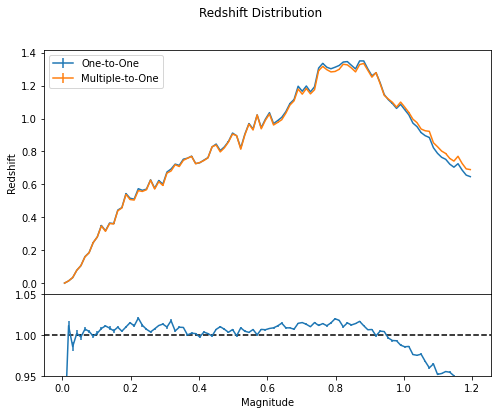

In [337]:
fig, axs = plt.subplots(2,gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6))
plt.subplots_adjust(hspace=0.,wspace=0.)
fig.suptitle('Redshift Distribution')
axs[0].errorbar(nz_bin_centers, nz_oto, nz_sig_oto)
axs[0].errorbar(nz_bin_centers, nz_otm, nz_sig_otm)
axs[0].set_ylabel('Redshift')

axs[1].axhline(1,c='black',ls='--')
axs[1].errorbar(nz_bin_centers,np.divide(nz_oto,nz_otm),
                propagate_division_error(np.divide(nz_oto,nz_otm),nz_oto,nz_sig_oto,nz_otm,nz_sig_otm))
axs[1].set_xlabel('Magnitude')
axs[1].set_ylim([.95,1.05])
axs[0].legend(['One-to-One','Multiple-to-One'])

In [322]:
test_statistic = lambda x: (np.mean(x), np.median(x), np.std(x))
def print_statistics(catalog, zmin, zmax):
    '''Helper function to print mean, median, and st.dev for a given catalog
    Inputs:
    ----------
    catalog - input catalog (DataFrame)
    zmin, zmax - redshift bin edges
    
    Returns:
    -------
    None
    '''
    bin_mask = (catalog['z']>zmin) & (catalog['z']<zmax)
    a,b = jackknife_resample(test_statistic, catalog[bin_mask]['z'], 10)
    print("Mean:", np.round(a[0],5), '±', np.round(b[0],5))
    print("Median:", np.round(a[1],5), '±', np.round(b[1],5))
    print("Std. Dev.:", np.round(a[2],5), '±', np.round(b[2],5))

In [313]:
zmin = 0.2; zmax = 1.2 
n_bins = 10
binlist = np.linspace(zmin,zmax,n_bins+1)
total_obj = pd.concat((total_oto, total_otm))

for i in range(n_bins):
    zmin = binlist[i]; zmax = binlist[i+1]
    print(zmin, zmax, "----------------------------------") 
    print('One-to-One:')
    print_statistics(total_oto, zmin, zmax)
    print('Multiple-to-One:')
    print_statistics(total_otm, zmin, zmax)
    print('Total:')
    print_statistics(total_obj, zmin, zmax)

0.2 0.30000000000000004 ----------------------------------
One-to-One:
Mean: 0.25145 ± 1e-05
Median: 0.25235 ± 1e-05
Std. Dev.: 0.02857 ± 1e-05
Multiple-to-One:
Mean: 0.2515 ± 1e-05
Median: 0.25244 ± 2e-05
Std. Dev.: 0.02853 ± 1e-05
Total:
Mean: 0.25148 ± 1e-05
Median: 0.2524 ± 1e-05
Std. Dev.: 0.02855 ± 0.0
0.30000000000000004 0.4 ----------------------------------
One-to-One:
Mean: 0.3509 ± 1e-05
Median: 0.35163 ± 2e-05
Std. Dev.: 0.02853 ± 0.0
Multiple-to-One:
Mean: 0.35103 ± 1e-05
Median: 0.35182 ± 2e-05
Std. Dev.: 0.02853 ± 0.0
Total:
Mean: 0.35097 ± 1e-05
Median: 0.35174 ± 1e-05
Std. Dev.: 0.02853 ± 0.0
0.4 0.5 ----------------------------------
One-to-One:
Mean: 0.45156 ± 1e-05
Median: 0.45189 ± 2e-05
Std. Dev.: 0.02877 ± 0.0
Multiple-to-One:
Mean: 0.4515 ± 1e-05
Median: 0.45179 ± 1e-05
Std. Dev.: 0.02879 ± 0.0
Total:
Mean: 0.45153 ± 0.0
Median: 0.45184 ± 1e-05
Std. Dev.: 0.02878 ± 0.0
0.5 0.6000000000000001 ----------------------------------
One-to-One:
Mean: 0.55126 ± 1e-05
Me

In [314]:
zmin = 0.2; zmax = 1.2 
n_bins = 5
binlist = np.linspace(zmin,zmax,n_bins+1)
total_obj = pd.concat((total_oto, total_otm))

for i in range(n_bins):
    zmin = binlist[i]; zmax = binlist[i+1]
    print(zmin, zmax, "----------------------------------") 
    print('One-to-One:')
    print_statistics(total_oto, zmin, zmax)
    print('Multiple-to-One:')
    print_statistics(total_otm, zmin, zmax)
    print('Total:')
    print_statistics(total_obj, zmin, zmax)

0.2 0.4 ----------------------------------
One-to-One:
Mean: 0.30682 ± 1e-05
Median: 0.31104 ± 2e-05
Std. Dev.: 0.05706 ± 1e-05
Multiple-to-One:
Mean: 0.30703 ± 1e-05
Median: 0.31128 ± 3e-05
Std. Dev.: 0.05707 ± 1e-05
Total:
Mean: 0.30694 ± 1e-05
Median: 0.31117 ± 1e-05
Std. Dev.: 0.05706 ± 0.0
0.4 0.6000000000000001 ----------------------------------
One-to-One:
Mean: 0.50495 ± 1e-05
Median: 0.50661 ± 1e-05
Std. Dev.: 0.05747 ± 1e-05
Multiple-to-One:
Mean: 0.50491 ± 1e-05
Median: 0.50658 ± 1e-05
Std. Dev.: 0.0575 ± 0.0
Total:
Mean: 0.50493 ± 1e-05
Median: 0.50659 ± 1e-05
Std. Dev.: 0.05749 ± 0.0
0.6000000000000001 0.8 ----------------------------------
One-to-One:
Mean: 0.7057 ± 1e-05
Median: 0.70835 ± 2e-05
Std. Dev.: 0.05744 ± 1e-05
Multiple-to-One:
Mean: 0.70559 ± 1e-05
Median: 0.70822 ± 1e-05
Std. Dev.: 0.05744 ± 0.0
Total:
Mean: 0.70564 ± 1e-05
Median: 0.70828 ± 1e-05
Std. Dev.: 0.05744 ± 0.0
0.8 1.0 ----------------------------------
One-to-One:
Mean: 0.89558 ± 1e-05
Median: 0.8

# Statistics with Truth Sample

In [1]:
#The following cells require the truth catalog, which is quite large...
#They also require the 'is_matched' and 'truthId' flags from the object catalog, which are not imported by default.

In [2]:
#It is useful to restart the kernel here so that you don't run out of memory when loading in the new data.
#Below are imports and functions that we may want to keep from earlier.
#You could skip this cell if you're not restarting the kernel.

import sys
sys.path.insert(0, "../../Assets/FoFCatalogMatching-master")
sys.path.insert(0, '/global/homes/l/levine/gcr-catalogs')
sys.path.insert(0, "../.local/lib/python3.7/site-packages")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from astropy.coordinates import SkyCoord

import FoFCatalogMatching
import GCRCatalogs

import kmeans_radec
from kmeans_radec import KMeans, kmeans_sample

import healpy as hp
import fitsio
import glob
import pandas as pd

import pyccl as ccl
import treecorr as tc
import pickle

def jackknife_resample(func, data, bins):
    '''Compute jackknife resampling for a given function 
    Inputs:
    ----------
    func - input function
    data - input data catalog
    bins - number of jackknife bins
    
    Returns:
    -------
    list of means for each output of the function
    list of standard deviations for each output of the function
    '''
    jk_bins = np.random.randint(0,high=bins,size=len(data))
    
    output_list = []
    for i in range(bins):
        output_list.append(func(data[jk_bins != i]))
    
    return np.mean(output_list,axis=0), np.std(output_list,axis=0)

def propagate_division_error(z, x, dx, y, dy):
    '''Helper function to propagate division error 
    '''
    return np.multiply(np.sqrt(np.add(np.square(np.divide(dx,x)),np.square(np.divide(dy,y)))),z)

In [3]:
#Define cuts on the catalogs
#Since these catalogs are really large, it is helpful to only look at 5 square degrees. 
#This should still give us reasonable statistics for the entire sample.
from GCR import GCRQuery
obj_mag_cuts = [
    GCRQuery('mag_i_lsst < 25'),
    GCRQuery((np.isfinite, 'mag_i_lsst')),
    GCRQuery('is_star == False'),
    GCRQuery('redshift_true < 1.2'),
    GCRQuery('ra < 65'), GCRQuery('ra > 60'),
    GCRQuery('ra < -35'), GCRQuery('ra > -40'),
]

truth_mag_cuts = [
    GCRQuery('mag_i_lsst < 25'),
    GCRQuery((np.isfinite, 'mag_i_lsst')),
    GCRQuery('ra < 65'), GCRQuery('ra > 60'),
    GCRQuery('ra < -35'), GCRQuery('ra > -40'),
]

In [4]:
#Import the Observed catalog
gc_matched = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd_matched_addon')
observed_data = pd.DataFrame(gc_matched.get_quantities(['ra', 'dec', 
                                     'n_neigh_truth', 'n_neigh_object', 
                                     'mag_i_lsst', 'is_matched', 'truthId'], filters=obj_mag_cuts,))

#Extra quantities of interest: 'redshift_true'

/global/homes/l/levine/gcr-catalogs/GCRCatalogs/register.py:366: UserWarning: `dc2_object_run2.2i_dr6_wfd_with_metacal` is currently an alias of `dc2_object_run2.2i_dr6_wfd_v1_with_metacal`.Please be advised that it will soon change to point to an updated version `dc2_object_run2.2i_dr6_v1_with_addons`.The updated version is already available in the master branch.
  self.rootname, self[self.ALIAS_KEY], online_config.get(self.ALIAS_KEY),


In [5]:
#This code displays a 2d histogram of blending and its bin values.
import matplotlib.colors
plt.figure(figsize=(10,6))
plt.hist2d(observed_data['n_neigh_truth'], observed_data['n_neigh_object'],
           range=[[1,10],[1,4]], bins=[np.arange(0.5, 11, 1), np.arange(0.5, 5, 1)],
           density=True, norm=matplotlib.colors.LogNorm(), cmap='pink_r')
plt.xticks(np.arange(1, 11, 1.0))
plt.yticks(np.arange(1, 5, 1.0))
plt.xlabel('True Neighbors')
plt.ylabel('Observed Neighbors')
plt.title('Proportion of Blends')
plt.colorbar()

'''neigh_hist = plt.hist2d(observed_data['n_neigh_truth'],observed_data['n_neigh_object'],
           range=[[1,10],[1,4]],bins=[np.arange(0.5, 11, 1), np.arange(0.5, 5, 1)],
           density=True,norm=matplotlib.colors.LogNorm(),cmap='pink_r')
print(np.round(neigh_hist[0],3))'''

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


ValueError: minvalue must be positive

ValueError: minvalue must be positive

<Figure size 720x432 with 2 Axes>

In [319]:
#Import the Truth catalog
gc_truth = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')
truth_data = pd.DataFrame(gc_truth.get_quantities(['ra', 'dec', 'mag_i_lsst', 'galaxy_id'], 
                                                  filters=truth_mag_cuts))

#Extra quantities of interest: ''

KeyboardInterrupt: 

In [ ]:
#We are going to cut the data so that the areas match.

#Remove missing tracts from random catalog
nside=2048
npix=hp.nside2npix(nside)
map_gal=np.bincount(hp.ang2pix(nside, observed_data['ra'], observed_data['dec'], lonlat=True), minlength=npix)
goodpx=np.where(map_gal>0)[0]
pxtru=hp.ang2pix(nside, truth_data['ra'], truth_data['dec'], lonlat=True)
good_tru = np.in1d(pxtru, goodpx)

truth_data = truth_data[good_tru]

In [ ]:
#We don't need the original catalog objects anymore.
%reset_selective -f gc_matched
%reset_selective -f gc_truth

In [ ]:
mask_otm = (observed_data['n_neigh_truth'] > 1)
mask_oto = (observed_data['n_neigh_truth'] == 1)
total_otm = observed_data[mask_otm]
total_oto = observed_data[mask_oto]

In [6]:
#Import the Truth catalog
gc_truth = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')
truth_data = pd.DataFrame(gc_truth.get_quantities(['ra', 'dec', 'mag_i_lsst'], 
                                                  filters=truth_mag_cuts))

#Extra quantities of interest: 'galaxy_id'

In [7]:
#You can uncomment the following lines to view flags for each catalog.
#sorted(gc_matched.list_all_quantities())
#sorted(gc_truth.list_all_quantities())
#galaxy_id

In [10]:
#We are going to cut the data so that the areas match.

#Remove missing tracts from random catalog
nside=2048
npix=hp.nside2npix(nside)
map_gal=np.bincount(hp.ang2pix(nside, observed_data['ra'], observed_data['dec'], lonlat=True), minlength=npix)
goodpx=np.where(map_gal>0)[0]
pxtru=hp.ang2pix(nside, truth_data['ra'], truth_data['dec'], lonlat=True)
good_tru = np.in1d(pxtru, goodpx)

truth_data = truth_data[good_tru]

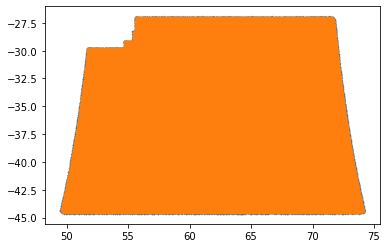

In [11]:
plt.scatter(truth_data['ra'][::100], truth_data['dec'][::100], s=0.1)
plt.scatter(observed_data['ra'][::100], observed_data['dec'][::100], s=0.1)

In [12]:
#We want to separate out the unrecognized blends -- ie. the blended truth objects which are not matched in the pipeline.


In [13]:
not_lost_objects = observed_data[ \
    ((observed_data['n_neigh_truth'] > observed_data['n_neigh_object']) & (observed_data['is_matched'] == True)) |
    (observed_data['n_neigh_truth'] == 1)]

In [14]:
not_lost_objects

,n_neigh_truth,n_neigh_object,dec,ra,is_matched,truthId
0,1,1,-44.629795,50.937950,False,10940305839
2,1,1,-44.633968,50.622709,False,11563663598
3,2,1,-44.639395,50.442544,True,11564005688
4,1,1,-44.637624,50.445157,True,11563831110
5,3,1,-44.635288,50.440542,True,11562943167
...,...,...,...,...,...,...
41426021,3,1,-26.962091,70.566767,True,1691940225
41426022,1,1,-26.951828,70.520904,True,1692273216
41426023,2,1,-26.952211,70.521210,True,1692273218
41426024,3,1,-26.947449,70.580537,True,1692282224


In [15]:
%reset_selective -f gc_matched
%reset_selective -f gc_truth
%reset_selective -f observed_data
%reset_selective -f map_gal
%reset_selective -f goodpx
%reset_selective -f good_tru

In [16]:
not_lost_objects = not_lost_objects[(not_lost_objects['ra'] > 55) & (not_lost_objects['ra'] < 65)
                     & (not_lost_objects['dec'] > -43) & (not_lost_objects['dec'] < -33)]
truth_data = truth_data[(truth_data['ra'] > 55) & (truth_data['ra'] < 65)
                     & (truth_data['dec'] > -43) & (truth_data['dec'] < -33)]

In [17]:
truth_data[truth_data.isin({'galaxy_id':np.array(not_lost_objects['truthId'])})['galaxy_id'] == False]

,ra,galaxy_id,mag_i_lsst,dec
665032,55.849968,9562500007,17.124317,-40.598123
665242,55.397505,9562500217,16.056618,-40.291112
665284,56.477380,9562500259,19.219462,-39.687951
665292,56.160903,9562500267,19.029768,-38.785362
665323,56.053405,9562500298,22.227047,-41.016244
...,...,...,...,...
64205340,64.930476,8952930385,23.503867,-38.626610
64206421,64.837356,8954141455,24.941353,-38.527751
64206698,64.825549,8954179818,24.767228,-38.724622
64206699,64.825827,8954179820,24.554366,-38.724728


In [19]:
#truth_data[(lost_truth_items['galaxy_id'] == False)]

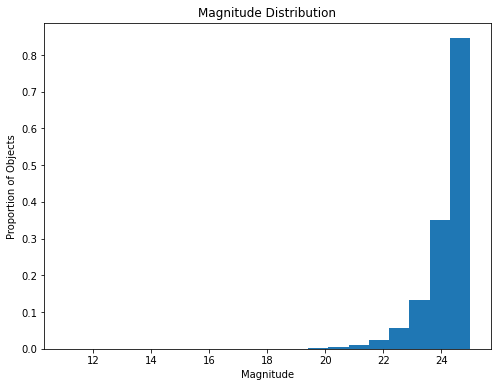

In [20]:
plt.figure(figsize=(8,6))
plt.xlabel('Magnitude')
plt.ylabel('Proportion of Objects')
plt.title('Magnitude Distribution')
a = plt.hist(truth_data[truth_data.isin({'galaxy_id':np.array(not_lost_objects['truthId'])})['galaxy_id'] == False]['mag_i_lsst'],
         bins=np.linspace(11,25,21), density=True)

In [21]:
len(a[0])

20

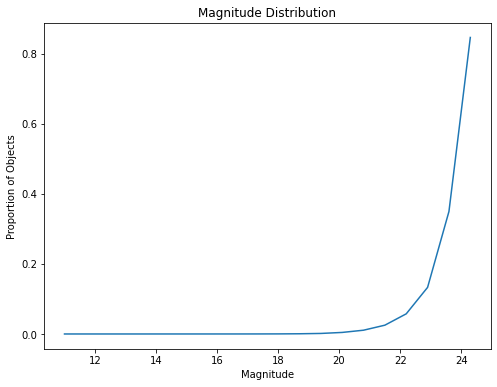

In [22]:
plt.figure(figsize=(8,6))
plt.xlabel('Magnitude')
plt.ylabel('Proportion of Objects')
plt.title('Magnitude Distribution')
plt.plot(a[1][:-1],a[0])

In [23]:
import pickle

filename = 'Lost_Magnitude_Distribution'
outfile = open(filename,'wb')

pickle.dump(a,outfile)
outfile.close()

In [2]:
filename = 'oto_Magnitude_Distribution'
infile = open(filename,'rb')
oto_mags = pickle.load(infile)

filename = 'otm_Magnitude_Distribution'
infile = open(filename,'rb')
otm_mags = pickle.load(infile)

NameError: name 'pickle' is not defined

In [32]:
lost_truth_items

,galaxy_id,ra,redshift_true,dec,mag_i_lsst
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
64242709,False,False,False,False,False
64242710,False,False,False,False,False
64242711,False,False,False,False,False
64242712,False,False,False,False,False


In [12]:
a = truth_data.isin({'galaxy_id':np.array(observed_data['truthId'])})

In [15]:
len(a[a['galaxy_id'] == True])

41356430

In [20]:
a[a['galaxy_id'] == True]

,ra,galaxy_id,dec,redshift_true,mag_i_lsst
2,False,True,False,False,False
4,False,True,False,False,False
5,False,True,False,False,False
6,False,True,False,False,False
7,False,True,False,False,False
...,...,...,...,...,...
64231185,False,True,False,False,False
64231187,False,True,False,False,False
64231188,False,True,False,False,False
64236805,False,True,False,False,False


In [22]:
#a[a['galaxy_id'] == True].Index()

AttributeError: 'DataFrame' object has no attribute 'Index'

In [24]:
np.array(a.index[a['galaxy_id'] == True])

array([       2,        4,        5, ..., 64231188, 64236805, 64238383])

In [ ]:
import cPickle
import gzip

filename = ''
outfile = gzip.open(filename,'wb')

pickle.dump([bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10],outfile)
outfile.close()

In [ ]:
def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)